### MF(Matrix Factorization) with item similarity based Collaborative Filtering concept

In [2]:
import pandas as pd
import numpy as np
import sys
# import tensorflow,keras
import os
import sys;
import numpy,sklearn
from pandas import read_csv;
# from keras.layers import Input, Embedding, Flatten, Lambda,Concatenate,Dense,Dropout
# from keras.models import Model
# from keras.initializers import RandomNormal
# from keras.regularizers import l2
# from keras.callbacks import EarlyStopping
# from keras import backend as K
import time
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler
# from keras.callbacks import ModelCheckpoint, EarlyStopping
import datetime
# import fasttext
import codecs
from bs4 import BeautifulSoup
import nltk
import os
import nltk.corpus,nltk.tokenize
from nltk.corpus import stopwords
nltk.download("stopwords")
import re
import string
import matplotlib.pyplot as plt
from pylab import *
# import plotly
# import plotly.graph_objects as go
import sklearn
from IPython import display
import ipywidgets as widgets
import sklearn.metrics as metrics
import operator
from sklearn.metrics.pairwise import cosine_similarity,pairwise_distances 
import implicit
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sourishd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Prep

In [82]:
#Sorting data based on time stamp

data = pd.read_csv("/home/sourishd/work/node2vec/movielens_small_dataset/user_item_action.csv")
# data = pd.DataFrame(rows[1:], columns=rows[0])
data['userID'] = data['itemId'].values
data['itemId'] = data['userId'].values
data['userId'] = data['userID'].values
print(data.head(5))
print(data.describe())
data["timeframe"] = pd.to_datetime(pd.to_numeric(data["timeframe"]), unit="s")
data_sort = data.sort_values(by=["timeframe"],ascending=True)
data_sort['month'] = data_sort["timeframe"].dt.month
data_sort['day'] = data_sort["timeframe"].dt.day
data_sort['day'] = data_sort['day'].astype('str')
data_sort['month'] = data_sort['month'].astype('str')
data_sort['month_day'] = data_sort[['month', 'day']].apply(lambda x: ''.join(x), axis=1)
data_sort['day'] = data_sort['month'].astype('str')
data_sort['userId'] = data_sort['userId'].astype('str')
day_sr_no = {}
# Mapping external to internal days
for i in range(len(data_sort)):
    month_day = data_sort['month_day'][i]
    if month_day not in day_sr_no :
        day_sr_no[month_day] = len(day_sr_no)
month_day = list(day_sr_no.keys())
sr_no = list(day_sr_no.values())
day_sr = pd.DataFrame({'month_day':month_day,'day_seq':sr_no})     
data_sort = pd.merge(left=data_sort.reset_index(drop=True),right=day_sr.reset_index(drop=True),how='left',on='month_day')
data_sort.sort_values(["userId",'day_seq'],ascending=True,inplace=True)
data_sort['day_seq'] = data_sort['day_seq'].astype('str')
data_sort['UserID_day'] = data_sort[['userId', 'day_seq']].apply(lambda x: ''.join(x), axis=1)
data_sort[['userId','itemId']] = data_sort[['userId','itemId']].astype('object')
data_sort.head(5)

   sessionId  userId  itemId action  timeframe eventdate  userID
0         48   24764       2  click       8863  4/9/2016   24764
1         48   24764       2  click     496381  4/9/2016   24764
2         48   24764       2  click     265216  4/9/2016   24764
3         48   24764       2  click     519975  4/9/2016   24764
4         48   24764       2  click     456437  4/9/2016   24764
           sessionId         userId         itemId     timeframe  \
count   38589.000000   38589.000000   38589.000000  3.858900e+04   
mean    23568.108762   67108.357511    7990.383840  3.093227e+05   
std     57752.677139   87058.184493    9295.471408  3.212191e+05   
min        48.000000       2.000000       2.000000  9.900000e+02   
25%      6832.000000   12352.000000    3547.000000  3.985200e+04   
50%     11060.000000   35376.000000    7594.000000  1.863580e+05   
75%     15194.000000   81452.000000   11398.000000  4.921860e+05   
max    436648.000000  574193.000000  241688.000000  1.199956e+06  

,sessionId,userId,itemId,action,timeframe,eventdate,userID,month,day,month_day,day_seq,UserID_day
895,91209,10000,10630,click,1970-01-01 02:05:03,2/6/2016,10000,1,1,11,0,100000
19729,11923,10002,9177,click,1970-01-03 06:38:45,2/15/2016,10002,1,1,13,7,100027
5846,5723,100044,3060,click,1970-01-01 05:36:53,1/18/2016,100044,1,1,11,0,1000440
14652,4082,100065,1800,click,1970-01-02 03:59:43,2/20/2016,100065,1,1,12,6,1000656
2389,2633,10007,1243,click,1970-01-01 03:07:32,2/14/2016,10007,1,1,11,0,100070


#### Identifying/Filtering users who appeared more than one days to simulate train-holdout test environment like offline/online A/B test

In [83]:
data_sort_user = data_sort[['userId','day_seq']]
data_sort_user.drop_duplicates(subset=None, keep='first', inplace=True)
user_id_repeat = pd.DataFrame(data_sort_user.groupby('userId').day_seq.nunique())
user_id_repeat['user'] = user_id_repeat.index
user_id_repeat.reset_index(drop=True, inplace = True)
user_id_repeat = user_id_repeat[(user_id_repeat['day_seq']>1)]
data_sort_user = data_sort_user[data_sort_user['userId'].isin(list(user_id_repeat['user']))]

#To get the last day for each user
max_day = data_sort_user.groupby('userId').day_seq.max()
user_id_repeat['max_day'] = max_day.values
user_id_repeat['user_day'] = user_id_repeat[['user', 'max_day']].apply(lambda x: ''.join(x), axis=1)

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Filtering out data including only repeat users- Makes sense as we solving re-targeting business problem

In [84]:
data_sort_repeat = data_sort[data_sort['userId'].isin(list(user_id_repeat['user']))]
data_sort_repeat.sort_values(["userId",'day_seq'],ascending=True,inplace=True)
data_sort_repeat = data_sort_repeat[["userId",'itemId','action','day_seq','timeframe','UserID_day']]
data_sort_repeat['day_seq'] = data_sort_repeat['day_seq'].astype('int')

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### train(common users of all but last day) and hold out test samples(common users of last day) split

In [85]:
#Train-test-1 day test
test = data_sort_repeat[data_sort_repeat['UserID_day'].isin(list(user_id_repeat['user_day']))]
train = data_sort_repeat[~data_sort_repeat['UserID_day'].isin(list(user_id_repeat['user_day']))]
print(train.shape)
print(test.shape)

(20273, 6)
(6682, 6)


In [86]:
train[['userId', 'itemId']] = train[['userId', 'itemId']].astype(str)
train['user_item'] = train[['userId', 'itemId']].apply(lambda x: '_'.join(x), axis=1)
training = train[['user_item','action']]
training = pd.DataFrame(pd.pivot_table(training, values='action', index=['user_item'],columns=['action'], aggfunc=np.count_nonzero))
training['user_item'] = training.index
training = pd.DataFrame(np.array(training))
training.columns = ['click', 'user_item']
training.fillna(0,inplace=True)
training['userId'] = training['user_item'].apply(lambda x: str(x).split('_')[0])
training['itemId'] = training['user_item'].apply(lambda x: str(x).split('_')[1])
training.drop('user_item',axis=1,inplace=True)
#training[['UserID', 'itemID']] = training[['UserID', 'itemID']].apply(pd.to_numeric, errors='coerce')
training['userId'] = pd.to_numeric(training['userId'])
training['itemId'] = training['itemId'].astype(int)
training.columns=['click', 'userId', 'itemId']
training.head(3)

/home/sourishd/.local/lib/python3.7/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,click,userId,itemId
0,2,10007,1243
1,2,10007,7357
2,2,100080,14782


#### Creating proper hold-out test sample user-item unique interaction

In [87]:
testing = test[['userId', 'itemId']]
testing.drop_duplicates(subset=None, keep='first', inplace=True)
testing.head(3)

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,userId,itemId
26427,10007,12005
19170,100080,9193
20261,100080,246


### For evaluation purpose keeping only users who are present both in training and testing

In [88]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 
final_users = intersection(list(train['userId'].unique()),list(test['userId'].unique()))
testing = testing[testing['userId'].isin(list(final_users))]
training = training[training['userId'].isin(list(final_users))]
# final_items = intersection(list(training['movieId'].unique()),list(testing['movieId'].unique()))
# testing = testing[testing['movieId'].isin(final_items)]
# training = training[training['movieId'].isin(final_items)]

In [89]:
print('unique_user in training:',len(list(training['userId'].unique())),'and unique_user in testing:',len(list(testing['userId'].unique())))

unique_user in training: 5746 and unique_user in testing: 5746


In [90]:
print('unique_user in training:',len(list(training['itemId'].unique())),'and unique_user in testing:',len(list(testing['itemId'].unique())))

unique_user in training: 8465 and unique_user in testing: 3397


In [91]:
testing[['userId', 'itemId']] = testing[['userId', 'itemId']].apply(pd.to_numeric)
training[['userId', 'itemId']] = training[['userId', 'itemId']].apply(pd.to_numeric)
testing.sort_values(['userId','itemId'],axis=0,inplace=True)
training.sort_values(['userId','itemId'],axis=0,inplace=True)

In [92]:
#training=pd.read_csv("/home/sourish/work/MF/data/item_based/hollisterco-de-1_final_train.csv")
user_dict = {}
for i,user in enumerate(sorted(training.userId.unique())):
    user_dict[user] = i
item_dict = {}
for i,item in enumerate(sorted(training.itemId.unique())):
    item_dict[user] = i    

In [93]:
training['userId'] = [user_dict[i] for i in training.userId]
testing['userId'] = [user_dict[i] for i in testing.userId]
training['score'] = training.click.values  #Currently using the simple formula,will be changed based on relative importance

In [ ]:
training.to_csv("/home/sourish/work/MF/data/item_based/hollisterco-de-1_final_train.csv",index=False,header=False)
testing.to_csv("/home/sourish/work/MF/data/item_based/hollisterco-de-1_final_test.csv",index=False)

In [94]:
item_user_matrix = pd.DataFrame(training.pivot(index='userId', columns='itemId', values='score'))
item_user_matrix.fillna(0,inplace=True)

In [95]:
item_dict = {}
for i,item in enumerate(item_user_matrix.columns):
    item_dict[item] = i

In [96]:
#Data normalization- wallet share(relative item preference)of each user

# item_user_matrix = item_user_matrix/item_user_matrix.sum(axis=1)

#user-item Sparse
item_user_matrix = sparse.csr_matrix(np.array(item_user_matrix))
item_user_matrix.data

array([2., 2., 2., ..., 2., 2., 2.])

### Cosine similarity

### item-sim

In [37]:
def recommend_items_to_users_cosine(item_user_matrix,metric='cosine',top_items=30):
    item_similarity = pairwise_distances(item_user_matrix.T, metric=metric)
    cos_similarity = item_user_matrix.dot(item_similarity) / np.array([np.abs(item_similarity).sum(axis=1)])
    nn = np.argsort(-cos_similarity)[:, :top_items]
    return nn
# nn = recommend_items_to_users_cosine(item_user_matrix, metric='cosine', top_items=30)
nn.shape

(5352, 30)

### user-sim

In [24]:
# mean_user_rating = item_user_matrix.mean(axis=1)
# user_similarity = pairwise_distances(item_user_matrix, metric='cosine')
# ratings_diff = (item_user_matrix - mean_user_rating)
# pred = mean_user_rating + user_similarity.dot(ratings_diff) / np.array([np.abs(user_similarity).sum(axis=1)]).T
# pred = mean_user_rating + user_similarity.dot(ratings_diff)
# pred.shape
# pred = user_similarity.dot(item_user_matrix)
pred = pred.T
nn = np.argsort(-pred)[:, :30]
nn.shape

(5352, 30)

In [21]:
def recommend_items_to_users_cosine_user(item_user_matrix,metric='cosine',top_items=30):
    mean_user_rating = item_user_matrix.mean(axis=1)
    user_similarity = pairwise_distances(item_user_matrix, metric='cosine')
    ratings_diff = (item_user_matrix - mean_user_rating[:, np.newaxis])
    pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    nn = np.argsort(-cos_similarity)[:, :top_items]
    return nn
nn = recommend_items_to_users_cosine_user(item_user_matrix, metric='cosine', top_items=30)
nn.shape

ValueError: input operand has more dimensions than allowed by the axis remapping

### Only MF-ALS

In [23]:
model = implicit.als.AlternatingLeastSquares(factors=16, regularization=0.1, iterations=100)
alpha_val = 15
model.fit((item_user_matrix * alpha_val).astype('double'))
def recommend_items_to_users_MF(item_user_matrix,metric='cosine',top_items=30):
    item_similarity = pairwise_distances(item_user_matrix.T, metric=metric)
    cos_similarity = item_user_matrix.dot(item_similarity) / np.array([np.abs(item_similarity).sum(axis=1)])
    nn = np.argsort(-cos_similarity)[:, :top_items]
    return nn
# nn = recommend_items_to_users_cosine(item_user_matrix, metric='cosine', top_items=30)
nn.shape

### MF-ALS algorithm to create user and item embeddings(64 latent feature with linear confidence index 15

In [97]:
alpha = 15
user_vecs, item_vecs = implicit.alternating_least_squares(
    (item_user_matrix*alpha).astype('double'), 
     factors=16, 
     regularization = 0.1, 
     iterations = 100)

print(user_vecs.shape, item_vecs.shape)

This method is deprecated. Please use the AlternatingLeastSquares class instead



(5746, 16) (8465, 16)


#### Calculate cosine similarity between respective user vector(embeddings numbers- 1 X64) and item-item embeddings(8437 X latent vector dimension).The matrix dot product will pick up similarity values(8437 X 1) for all products.
#### Sorting the similarity values to arrive to get top n items(30 or 5) for respective user.

In [103]:
def recommend_items_to_users(indexes, users_vec, items_vec, top_items=25):
    cos_similarity = cosine_similarity(
        users_vec[indexes, :], items_vec)
#     similarity = np.dot(users_vec,items_vec.T)
    nn = np.argsort(-cos_similarity)[:, :top_items]
    return nn

#### product recommendation basis on MF + item similarity based CF approach

In [105]:
indexes = list(range(user_vecs.shape[0]))
#indexes = list[0]
nn = recommend_items_to_users(indexes, user_vecs, item_vecs)
print(nn.shape, nn[:2, :])

(5746, 25) [[8061 8131 7327 2371 7165  522 4151 4328 4722 2427 6879 3870 1970 7306
  2071 1149  696 6283 6362 5319  760  662 2567 1919 6263]
 [3248 8081 3638 2000 3086 1982  503 6488 7299 1856 2358 7508  379 4455
  3288 2831   43 5188  658 6894 7853 2455 1503 3014 1585]]


In [592]:
def diff(lst1, lst2):
    lst2 = set(lst2)
    return [item for item in lst1 if item not in lst2]
diff_reco = []
for i in range(nn.shape[0]):
    reco_list = list(nn[i])
    l = list(testing[testing['userId'] == i]['itemId'])
    l = [item_dict[j] if j in item_dict.keys() else 9999 for j in l] 
    new = diff(reco_list,l)
    new = new[:5]
    diff_reco.append(new)
diff_reco = np.array(diff_reco)
diff_reco.shape

(5352, 5)

In [579]:
final_reco = []
for i in range(len(diff_reco)):
    l1 = list(nn1[i])
    l2 = list(diff_reco[i])
    l = [*l1, *l2]
    l = list(dict.fromkeys(l))
    final_reco.append(l)
final_reco = np.array(final_reco)   

In [99]:
#Reversing user-dict

user_rev_dict = {v: k for k, v in user_dict.items()}
user_id = pd.Series(list(user_rev_dict.values())).values
user_id = user_id[:,np.newaxis]
user_id = user_id.reshape((len(user_id)))
user_id

array([     2,     42,     43, ..., 523927, 526609, 548767])

#### Training and testing user specific list of items

In [493]:
testing[['userId']] = testing[['userId']].apply(pd.to_numeric, errors='coerce')
#testing[['AdmediumID']] = testing[['AdmediumID']].astype(str)
users = []
items = []
for u,i in enumerate(np.unique(testing['userId'])):
    user = user_rev_dict[u]
    users.append(user)
    l = list(testing[testing['userId'] == i]['itemId'])
    item = [item_dict[x] if x in item_dict.keys() else 9999 for x in l]
    items.append(item)
test_reco = pd.DataFrame({'user_id':user_id,'items':items})
print('list of items for users during test')
test_reco.head(3)

list of items for users during test


,user_id,items
0,0,[3669]
1,1,[5372]
2,2,[2092]


In [494]:
training[['userId']] = training[['userId']].apply(pd.to_numeric, errors='coerce')
#training[['AdmediumID']] = training[['AdmediumID']].astype(str)
users = []
items = []
for u,i in enumerate(np.unique(training['userId'])):
    user = user_rev_dict[u]
    users.append(user)
    l = list(training[training['userId'] == i]['itemId'])
    item = [item_dict[x] for x in l]
    items.append(item)
train_reco = pd.DataFrame({'user_id':user_id,'items':items}) 
print('list of items for users during training')
train_reco.head(3)

list of items for users during training


,user_id,items
0,0,[3669]
1,1,"[112, 1247, 1385, 1998, 2003, 2317, 3467, 4226..."
2,2,"[2067, 4830]"


In [495]:
#Calculating actual match rate(atleast one product match) between training vs test

cnt = 0
match = []
for i in range(train_reco.shape[0]):
    l1=train_reco['items'][i]
    l2=test_reco['items'][i]
    if len(intersection(l1,l2)) > 0:
        cnt+=1
        match.append(1)
    else:
        match.append(0)
print(cnt/train_reco.shape[0]) 

0.312406576980568


### Insight

#### There is 60% match rate(at least for one common item)between train(common users of all but last day) and hold out test samples(common users of last day). The pattern shows that users are mostly sticking with few options and as 'view' takes the majority of the user interaction, showing the same/similar items might increase the match-rate(True positive and AUC) during the real test(offline or A/B test) as well.

In [100]:
testing[['userId']] = testing[['userId']].apply(pd.to_numeric, errors='coerce')
#testing[['AdmediumID']] = testing[['AdmediumID']].astype(str)
users = []
items = []
for u,i in enumerate(np.unique(testing['userId'])):
    user = user_rev_dict[u]
    users.append(user)
    l = list(testing[testing['userId'] == i]['itemId'])
    item = [item_dict[x] if x in item_dict.keys() else 9999 for x in l]
    items.append(item)
test_reco = pd.DataFrame({'user_id':user_id,'items':items})
print('list of items for users during test')

list of items for users during test


In [106]:
#Geting list of items user chosen from recommended and test data set
nn = np.array(nn)
NN = [list(nn[i]) for i in range(len(nn))]
test_reco = pd.DataFrame({'user_id':user_id,'items':items})
#train_reco = pd.DataFrame({'user_id':user_id,'items':items})
recommended = pd.DataFrame({'user_id':user_id,'items':NN})

### Sneak-peak between recommended vs. actual 

In [107]:
print(test_reco.head(10))
recommended.head(10)

   user_id        items
0        2       [8061]
1       42        [693]
2       43       [7744]
3       47  [697, 3987]
4       49       [2484]
5       59       [7791]
6       60       [9999]
7       61       [4235]
8       63       [9999]
9       71       [6619]


,user_id,items
0,2,"[8061, 8131, 7327, 2371, 7165, 522, 4151, 4328..."
1,42,"[3248, 8081, 3638, 2000, 3086, 1982, 503, 6488..."
2,43,"[4516, 4977, 3860, 150, 3949, 4067, 7744, 3171..."
3,47,"[3987, 6268, 1428, 697, 6487, 554, 5704, 4367,..."
4,49,"[2645, 1326, 909, 5652, 7607, 7712, 8242, 4967..."
5,59,"[2343, 9, 3280, 7791, 544, 5991, 7742, 7074, 7..."
6,60,"[6607, 377, 3597, 7172, 8286, 3184, 353, 413, ..."
7,61,"[333, 6904, 209, 7125, 161, 1887, 3482, 1199, ..."
8,63,"[1515, 7223, 3348, 7980, 6490, 991, 808, 502, ..."
9,71,"[4323, 265, 5921, 471, 4782, 737, 5441, 5941, ..."


### Apparently Can see a high match-rate(TP)

In [108]:
#Calculating actual match rate(atleast one product match) between recommended vs. actual

cnt = 0
match = []
for i in range(recommended.shape[0]):
    l1=recommended['items'][i]
    l2=test_reco['items'][i]
    if len(intersection(l1,l2)) > 0:
        cnt+=1
        match.append(1)
    else:
        match.append(0)
print(cnt/recommended.shape[0])    

0.5490776192133658


### showing the same/similar items might increase the match-rate(True positive and AUC) during the real test(offline or A/B test) as well.

### Comparing performance with popularity based product recommendation

In [109]:
pop_30 = list(np.argsort(-np.sum(item_user_matrix.toarray(),axis=0))[:30])

### Functions to calculate performance metrics

In [113]:
def mean_reciprocal_rank(rs):
    """Score is reciprocal of the rank of the first relevant item
    First element is 'rank 1'.  Relevance is binary (nonzero is relevant).
    Example from http://en.wikipedia.org/wiki/Mean_reciprocal_rank
    >>> rs = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.61111111111111105
    >>> rs = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0]])
    >>> mean_reciprocal_rank(rs)
    0.5
    >>> rs = [[0, 0, 0, 1], [1, 0, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.75
    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Mean reciprocal rank
    """
    rs = (np.asarray(r).nonzero()[0] for r in rs)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in rs])

def precision_at_k(r, k):
    """Score is precision @ k
    Relevance is binary (nonzero is relevant).
    >>> r = [0, 0, 1]
    >>> precision_at_k(r, 1)
    0.0
    >>> precision_at_k(r, 2)
    0.0
    >>> precision_at_k(r, 3)
    0.33333333333333331
    >>> precision_at_k(r, 4)
    Traceback (most recent call last):
        File "<stdin>", line 1, in ?
    ValueError: Relevance score length < k
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Precision @ k
    Raises:
        ValueError: len(r) must be >= k
    """
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)


def average_precision(r):
    """Score is average precision (area under PR curve)
    Relevance is binary (nonzero is relevant).
    >>> r = [1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
    >>> delta_r = 1. / sum(r)
    >>> sum([sum(r[:x + 1]) / (x + 1.) * delta_r for x, y in enumerate(r) if y])
    0.7833333333333333
    >>> average_precision(r)
    0.78333333333333333
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Average precision
    """
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)


def mean_average_precision(rs):
    """Score is mean average precision
    Relevance is binary (nonzero is relevant).
    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1]]
    >>> mean_average_precision(rs)
    0.78333333333333333
    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1], [0]]
    >>> mean_average_precision(rs)
    0.39166666666666666
    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Mean average precision
    """
    return np.mean([average_precision(r) for r in rs])

def precision_at_k(r, k):
    """Score is precision @ k
    Relevance is binary (nonzero is relevant).
    >>> r = [0, 0, 1]
    >>> precision_at_k(r, 1)
    0.0
    >>> precision_at_k(r, 2)
    0.0
    >>> precision_at_k(r, 3)
    0.33333333333333331
    >>> precision_at_k(r, 4)
    Traceback (most recent call last):
        File "<stdin>", line 1, in ?
    ValueError: Relevance score length < k
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Precision @ k
    Raises:
        ValueError: len(r) must be >= k
    """
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)
def check_one_match(act_prods, pred_prods, pop_prods, top_n=30):
    is_pred_match = 1 if bool(set(act_prods).intersection(set(pred_prods[:top_n]))) else 0
    is_pop_match = 1 if bool(set(act_prods).intersection(set(pop_prods[:top_n]))) else 0
    return (is_pred_match, is_pop_match)

def dcg_at_k(r, k, method=0):
    """Score is discounted cumulative gain (dcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> dcg_at_k(r, 1)
    3.0
    >>> dcg_at_k(r, 1, method=1)
    3.0
    >>> dcg_at_k(r, 2)
    5.0
    >>> dcg_at_k(r, 2, method=1)
    4.2618595071429155
    >>> dcg_at_k(r, 10)
    9.6051177391888114
    >>> dcg_at_k(r, 11)
    9.6051177391888114
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    """Score is normalized discounted cumulative gain (ndcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> ndcg_at_k(r, 1)
    1.0
    >>> r = [2, 1, 2, 0]
    >>> ndcg_at_k(r, 4)
    0.9203032077642922
    >>> ndcg_at_k(r, 4, method=1)
    0.96519546960144276
    >>> ndcg_at_k([0], 1)
    0.0
    >>> ndcg_at_k([1], 2)
    1.0
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

def get_performance_metrics(user,user_true, user_vecs, item_vecs, pop_items, top_n,top_nn):
    #item_score = cosine_similarity(user_vecs[[users_u.index(u_id)], :], item_vecs).reshape(-1)
    #indexes = user_dict[user]
    item_score = cosine_similarity(user_vecs[user, :].reshape(1,-1), item_vecs)
    #item_score = -np.sort(-item_score).reshape(-1)
    item_recc = np.argsort(-item_score.reshape(-1))[:top_nn]
    #item_recc_org_id = [i[0] for i in item_scores[:top_n]]
    #item_recc = [items_u.index(i) for i in item_recc_org_id]
    try:
        #item_ind = [items_u.index(p_id) for p_id in user_true]
        item_act = np.zeros(item_vecs.shape[0])
        for i_ind in user_true:
            item_act[i_ind] = 1
        pop = np.zeros(item_vecs.shape[0])
        rec = np.zeros(item_vecs.shape[0])
        for p_ind in pop_items[:top_n]:
            pop[p_ind] = 1
        for r_ind in item_recc:
            rec[r_ind] = 1
        match =[1 if item_recc[i] in user_true else 0 for i in range(top_nn)][:top_nn] 
        MAR = mean_reciprocal_rank(match)
        MAP = average_precision(match)
        ndcg = ndcg_at_k(match,5)
        match_p = [1 if pop[i] in user_true else 0 for i in range(len(pop_items))][:top_n]
        MAR_p = mean_reciprocal_rank(match_p)
        MAP_p = average_precision(match_p)
        ndcg_p = ndcg_at_k(match_p,30)
        auc = metrics.roc_auc_score(item_act, rec)
        auc_pop = metrics.roc_auc_score(item_act, pop)
    except:
        print("failing")
        auc, auc_pop,MAR,MAR_p,MAP,MAP_p,ndcg,ndcg_p = 0.5,0.5,0,0,0,0,0,0
    return (auc, auc_pop, MAR,MAR_p,MAP,MAP_p,ndcg,ndcg_p,item_score)

#### Example

In [125]:
#Performance metric dataset 

# reco_df = pd.DataFrame({'user_id':user_id,'items_act':items,'item_rec':nn})
reco_df['match'] = reco_df.apply(lambda row: check_one_match(row[1], row[2], pop_30,top_n=5), axis=1)
reco_df['u_id'] = reco_df.index
measures = reco_df.apply(lambda row: get_performance_metrics(row[4],row[1], user_vecs,item_vecs, pop_30,top_n=30,top_nn=5), axis=1)
reco_df['score'] = [i[8].reshape(-1) for i in measures]
reco_df['auc'] = [(i[0],i[1]) for i in measures]
reco_df['MRR'] = [(i[2],i[3]) for i in measures]
reco_df['MAP'] = [(i[4],i[5]) for i in measures]
reco_df['NDCG'] = [(i[6],i[7]) for i in measures]
reco_df.head(5)

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing
failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing
failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
/home/sourishd/anaconda3/lib/python3.7/site-packages

failing
failing


,user_id,items_act,item_rec,match,u_id,score,auc,MRR,MAP,NDCG
0,2,[8061],"[8061, 8131, 7327, 2371, 7165, 522, 4151, 4328...","(1, 0)",0,"[0.059452817, 0.3221054, 0.22521141, 0.3879951...","(0.9997637051039698, 0.49822778827977315)","(0.2, 0.0)","(1.0, 0.0)","(1.0, 0.0)"
1,42,[693],"[3248, 8081, 3638, 2000, 3086, 1982, 503, 6488...","(0, 0)",1,"[-0.23887593, -0.20910771, 0.1940965, 0.230107...","(0.4997046313799622, 0.49822778827977315)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"
2,43,[7744],"[4516, 4977, 3860, 150, 3949, 4067, 7744, 3171...","(0, 0)",2,"[-0.17566201, -0.03774713, 0.41954368, 0.33786...","(0.4997046313799622, 0.49822778827977315)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"
3,47,"[697, 3987]","[3987, 6268, 1428, 697, 6487, 554, 5704, 4367,...","(1, 0)",3,"[0.124555446, 0.23519516, 0.36107332, 0.543469...","(0.999822757887274, 0.49822757887274016)","(0.4, 0.0)","(0.8333333333333333, 0.0)","(0.8154648767857288, 0.0)"
4,49,[2484],"[2645, 1326, 909, 5652, 7607, 7712, 8242, 4967...","(0, 0)",4,"[0.35766912, 0.10939008, 0.23260398, 0.1758496...","(0.4997046313799622, 0.49822778827977315)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"


In [130]:
# reco_df = pd.DataFrame({'user_id':user_id,'items_act':items,'item_rec':list(nn)})
reco_df['match'] = reco_df.apply(lambda row: check_one_match(row[1], row[2], pop_30,top_n=5), axis=1)
item_score = cosine_similarity(user_vecs[0, :].reshape(1,-1), item_vecs)
item_recc = np.argsort(-item_score.reshape(-1))[:30]
item_act = np.zeros(item_vecs.shape[0])
for i_ind in reco_df.items_act[0]:
    item_act[i_ind] = 1
pop = np.zeros(item_vecs.shape[0])
rec = np.zeros(item_vecs.shape[0])
for p_ind in pop_30[:30]:
    pop[p_ind] = 1
for r_ind in item_recc:
    rec[r_ind] = 1
match =[1 if item_recc[i] in reco_df.items_act[0] else 0 for i in range(30)][:5] 
MAR = mean_reciprocal_rank(match)
match_p = [1 if pop[i] in reco_df.items_act[0] else 0 for i in pop_30][:5]
MAR_p = mean_reciprocal_rank(match_p)
auc = metrics.roc_auc_score(item_act, rec)
auc_pop = metrics.roc_auc_score(item_act, pop)
print(auc, auc_pop, MAR,MAR_p,item_score)

0.9982868620037807 0.49822778827977315 0.2 0.0 [[ 0.05945282  0.3221054   0.22521141 ... -0.1401619   0.07609217
   0.266494  ]]


/home/sourishd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.


In [131]:
#Performance
match = [i[0] for i in reco_df['match']]
match_p = [i[1] for i in reco_df['match']]
auc = [i[0] for i in reco_df['auc']]
auc_p = [i[1] for i in reco_df['auc']]
MAP_5 = [i[0] for i in reco_df['MAP']]
MAP_p = [i[1] for i in reco_df['MAP']]
MRR_5 = [i[0] for i in reco_df['MRR']]
MRR_p = [i[1] for i in reco_df['MRR']]
print('hitrate/TP for MF-item similarity:', np.mean(match)) 
print('hitrate/TP_popularity:', np.mean(match_p)) 
print('AUC for MF-item similarity:', np.mean(auc)) 
print('AUC_popularity:', np.mean(auc_p)) 
print('MAP for MF-item similarity:', np.mean(MAP_5)) 
print('MAP_popularity:', np.mean(MAP_p)) 
print('MRR for MF-item similarity:', np.mean(MRR_5)) 
print('MRR_popularity:', np.mean(MRR_p))

hitrate/TP for MF-item similarity: 0.3759136790810999
hitrate/TP_popularity: 0.017925513400626522
AUC for MF-item similarity: 0.6793816738033467
AUC_popularity: 0.5257112031895476
MAP for MF-item similarity: 0.2505627102912171
MAP_popularity: 0.0001740341106856944
MRR for MF-item similarity: 0.07647058823529412
MRR_popularity: 0.0001740341106856944


### Science behind scoring and selection of items(product recommendation)

#### Deciling and Rank-ordering - score for a particular user id- 1312359294

In [872]:
#Score drops-KS and rank order plot

#item_score = -np.sort(-item_score).reshape(-1)
ranking = pd.DataFrame(item_score.reshape(-1))
ranking.columns = ['score']
ranking['predicted']=rec
ranking['actual'] = item_act
ranking = ranking.sort_values('score',ascending = False,axis = 0)
ranking['decile'] = pd.qcut(ranking['score'], 10, labels=np.arange(10, 0, -1))
print(ranking.head(10))
mean = pd.DataFrame(ranking.groupby(by="decile").mean().reset_index(drop=True))
mean.columns = ['avg_score','avg_pred','avg_actual']
mean['max_score'] = pd.DataFrame(ranking[["decile",'score']].groupby(by="decile").max().reset_index(drop=True))
mean['min_score'] = pd.DataFrame(ranking[["decile",'score']].groupby(by="decile").min().reset_index(drop=True))
mean['pred_cnt'] = pd.DataFrame(ranking[["decile",'predicted']].groupby(by="decile").sum().reset_index(drop=True))
mean['actual_cnt'] = pd.DataFrame(ranking[["decile",'actual']].groupby(by="decile").sum().reset_index(drop=True))
mean['decile'] = range(10,0,-1) 
mean['cnt'] = pd.DataFrame(ranking[["decile",'predicted']].groupby(by="decile").count().reset_index(drop=True))
mean = mean.sort_values('avg_score',ascending = False,axis = 0)
mean['cum_event_perc'] = mean['actual_cnt'].cumsum()/np.sum(mean['actual_cnt']) * 100
mean['cum_event_perc']
mean['cum_nonevent_perc'] = (mean['cnt']-mean['actual_cnt']).cumsum()/np.sum((mean['cnt']-mean['actual_cnt'])) * 100
mean['ks_score'] = mean['cum_event_perc']-mean['cum_nonevent_perc']
mean.index = range(0,10,1)
mean

         score  predicted  actual decile
1985  0.719134        1.0     1.0      1
3430  0.689931        1.0     1.0      1
3399  0.614965        1.0     0.0      1
3396  0.583950        1.0     0.0      1
3395  0.582229        1.0     0.0      1
3403  0.570351        1.0     0.0      1
3402  0.557450        1.0     0.0      1
1587  0.537944        1.0     0.0      1
3423  0.533600        1.0     0.0      1
3401  0.514567        1.0     0.0      1


,avg_score,avg_pred,avg_actual,max_score,min_score,pred_cnt,actual_cnt,decile,cnt,cum_event_perc,cum_nonevent_perc,ks_score
0,0.249739,0.083799,0.005587,0.719134,0.154811,30.0,2.0,1,358,100.0,9.971989,90.028011
1,0.123257,0.000000,0.000000,0.154479,0.100450,0.0,0.0,2,357,100.0,19.971989,80.028011
2,0.082078,0.000000,0.000000,0.100189,0.065024,0.0,0.0,3,357,100.0,29.971989,70.028011
3,0.052028,0.000000,0.000000,0.064980,0.040063,0.0,0.0,4,357,100.0,39.971989,60.028011
4,0.027636,0.000000,0.000000,0.039802,0.014829,0.0,0.0,5,357,100.0,49.971989,50.028011
5,0.003436,0.000000,0.000000,0.014822,-0.009611,0.0,0.0,6,357,100.0,59.971989,40.028011
6,-0.023328,0.000000,0.000000,-0.009618,-0.037881,0.0,0.0,7,357,100.0,69.971989,30.028011
7,-0.051347,0.000000,0.000000,-0.037967,-0.065759,0.0,0.0,8,357,100.0,79.971989,20.028011
8,-0.083931,0.000000,0.000000,-0.065805,-0.107131,0.0,0.0,9,357,100.0,89.971989,10.028011
9,-0.156819,0.000000,0.000000,-0.107214,-0.413140,0.0,0.0,10,358,100.0,100.000000,0.000000


## Insights - 

### High KS(Kolmogorov-Smirnov)score is showing that scores can differentiate an event(recommended item) and non-event(item not recommended for user)

### Also we can able to capture all events(recommended items for user) in 1st decile itself

### This means scores and our top items selection has coherence.

Text(0.5, 1.0, 'cumulative gain')

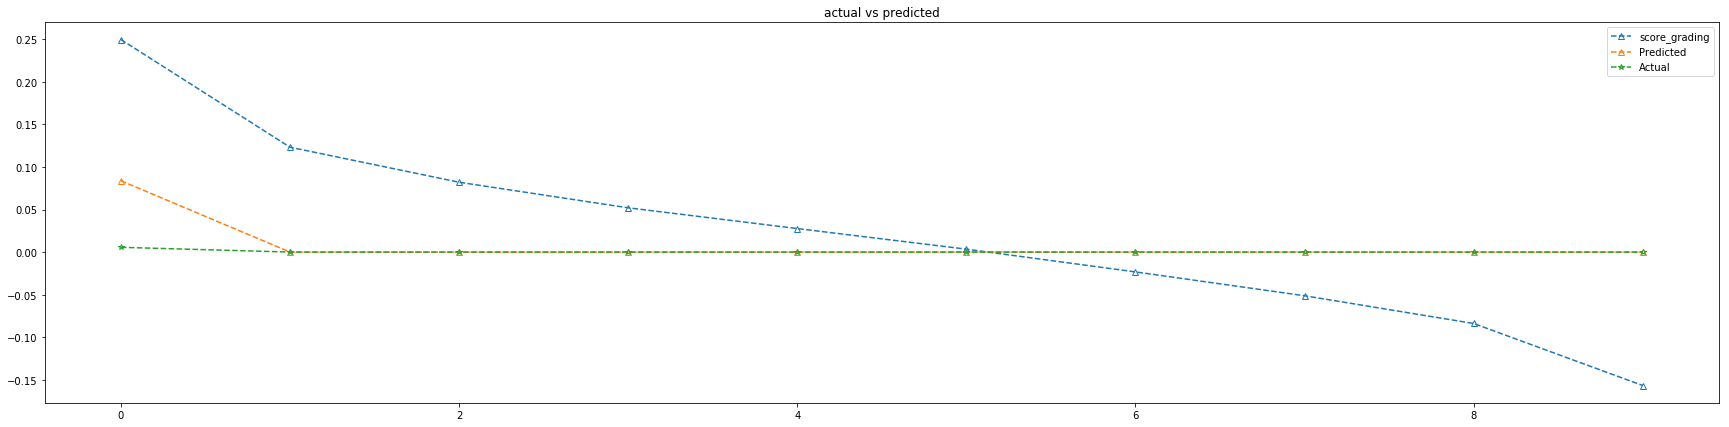

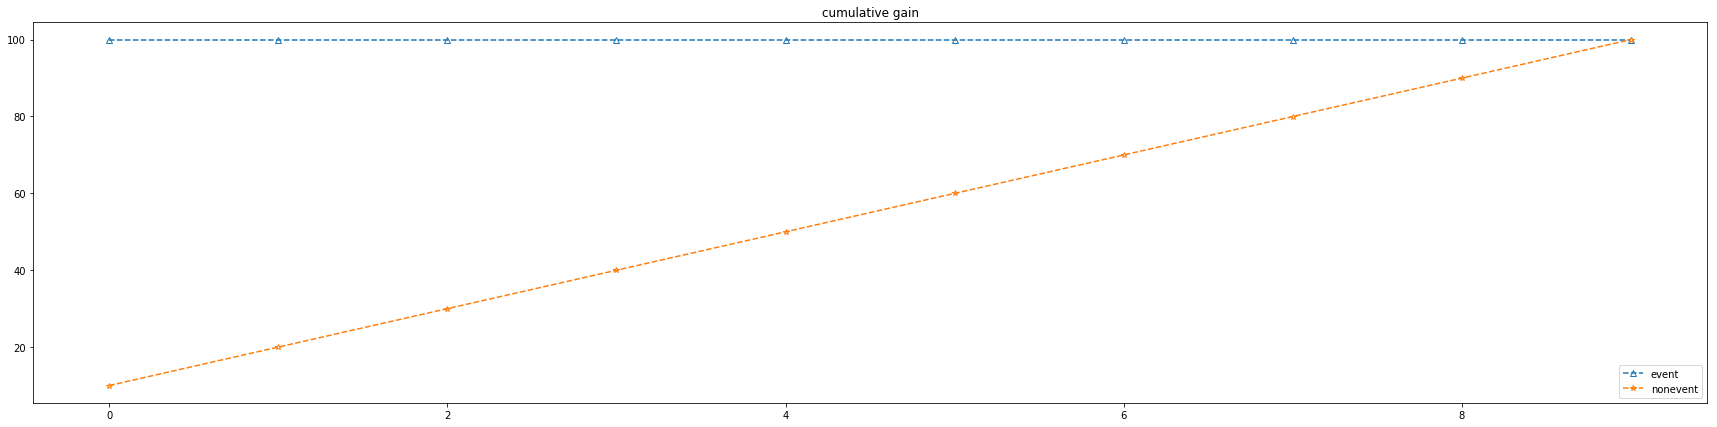

In [873]:
plt.figure(figsize=(30,7))
plt.plot(mean['avg_score'], label='score_grading',marker="^",ls='--',fillstyle='none')
plt.plot(mean['avg_pred'], label='Predicted',marker="^",ls='--',fillstyle='none')
plt.plot(mean['avg_actual'], label='Actual', marker="*",ls='--',fillstyle='none')
plt.legend()
plt.title('actual vs predicted')

plt.figure(figsize=(30,7))
plt.plot(mean['cum_event_perc'], label='event',marker="^",ls='--',fillstyle='none')
plt.plot(mean['cum_nonevent_perc'], label='nonevent', marker="*",ls='--',fillstyle='none')
plt.legend()
plt.title('cumulative gain')

#### We can see that average scores across deciles has monotonic decreasing trend,which is scientifically correct in terms of score generation 

### Comparing with offline test performance

In [874]:
#Sparcity log data

mfeu_log = pd.read_csv('/home/sourish/work/MF/log/nautica-matrix.log')
alseu_log = pd.read_csv('/home/sourish/work/MF/log/als_conf.log')
mfus_log = pd.read_csv('/home/sourish/work/MF/log/nautica-matrix_us.log')
alsus_log = pd.read_csv('/home/sourish/work/MF/log/als_conf_us.log')

In [875]:
def sparcity(log):
    Advertiser = []
    users_no = []
    items_no=[]
    Number_ratings =[]
    Sparsity = []
    expired = []
    for i in range(len(log)):
        if log.iloc[:,0][i].strip().split(':')[0] == 'Advertiser':
            Advertiser.append(log.iloc[:,0][i].strip().split(':')[1])
        if log.iloc[:,0][i].strip().split(':')[0] == 'Number of users':
            users_no.append(log.iloc[:,0][i].strip().split(':')[1])
        if log.iloc[:,0][i].strip().split(':')[0] == 'Number of items':
            items_no.append(log.iloc[:,0][i].strip().split(':')[1])
        if log.iloc[:,0][i].strip().split(':')[0] == 'Number of interactions/ratings':
            Number_ratings.append(log.iloc[:,0][i].strip().split(':')[1]) 
        if log.iloc[:,0][i].strip().split(':')[0] == 'Sparsity':
            Sparsity.append(log.iloc[:,0][i].strip().split(':')[1]) 
        if log.iloc[:,0][i].strip().split(':')[0] == 'Percentage of expired items':
            expired.append(log.iloc[:,0][i].strip().split(':')[1]) 
    return pd.DataFrame({'Advertiser':Advertiser, 'users_no':users_no, 'items_no':items_no,'Number_ratings':Number_ratings,'Sparsity':Sparsity,'expired':expired})
#def main():
    #log = pd.read_csv('/home/sourish/work/MF/log/als_conf.log')
    #return(sparcity(log))
#if __name__ == '__main__':
    #main()

In [876]:
#Preparing sparsity data

sparce_eu_mf = sparcity(mfeu_log)
sparce_eu_als = sparcity(alseu_log)
sparce_us_mf = sparcity(mfus_log)
sparce_us_als = sparcity(alsus_log)
sparce_mf = sparce_us_mf.append(sparce_eu_mf)
sparce_als = sparce_us_als.append(sparce_eu_als)
sparce_mf.shape
sparce_als.shape
#sparce['Advertiser'] = sparce['Advertiser'].str.strip()
#result.columns

(251, 6)

In [877]:
#Result summary of US and EU advertisers

result_eu = pd.read_csv('/home/sourish/work/MF/log/results_eu.csv',sep=",")
result_eu['zone'] = 'EU'
result_us = pd.read_csv('/home/sourish/work/MF/log/results_us.csv',sep=",")
result_us['zone'] = 'US'
result = result_us.append(result_eu)
result.drop(['Unnamed: 0','Unnamed: 39'],axis = 1, inplace = True)
result.dropna(inplace=True)
result=result[1:]
result.rename(columns={' Advertiser ':'Advertiser'},inplace=True)
result['Advertiser'] = result['Advertiser'].str.strip()
result.shape

(235, 39)

In [878]:
result_MF = pd.concat([result.reset_index(drop=True), sparce_mf.drop('Advertiser',axis=1).reset_index(drop=True)], axis=1)
result_als = pd.concat([result.reset_index(drop=True), sparce_als.drop('Advertiser',axis=1).reset_index(drop=True)], axis=1)
result_MF.dropna(inplace=True)
result_als.dropna(inplace=True)
result[['nautica: Recall','nautica-matrix: Recall','nautica-test-als: Recall',
       'nautica-test-lmf: Recall', 'nautica: Precision',
       'nautica-matrix: Precision', 'nautica-test-als: Precision',
       'nautica-test-lmf: Precision', 'nautica: F1-Score',
       'nautica-matrix: F1-Score', 'nautica-test-als: F1-Score',
       'nautica-test-lmf: F1-Score']] = result[['nautica: Recall','nautica-matrix: Recall','nautica-test-als: Recall',
       'nautica-test-lmf: Recall', 'nautica: Precision',
       'nautica-matrix: Precision', 'nautica-test-als: Precision',
       'nautica-test-lmf: Precision', 'nautica: F1-Score',
       'nautica-matrix: F1-Score', 'nautica-test-als: F1-Score',
       'nautica-test-lmf: F1-Score']].replace('%','',regex=True)
cols = ['nautica: Test count',
       'nautica-matrix: Test count', 'nautica-test-als: Test count',
       'nautica-test-lmf: Test count', 'nautica: True positives',
       'nautica-matrix: True positives', 'nautica-test-als: True positives',
       'nautica-test-lmf: True positives', 'nautica: DCG',
       'nautica-matrix: DCG', 'nautica-test-als: DCG', 'nautica-test-lmf: DCG',
       'nautica: Recall', 'nautica-matrix: Recall', 'nautica-test-als: Recall',
       'nautica-test-lmf: Recall', 'nautica: Precision',
       'nautica-matrix: Precision', 'nautica-test-als: Precision',
       'nautica-test-lmf: Precision', 'nautica: F1-Score',
       'nautica-matrix: F1-Score', 'nautica-test-als: F1-Score',
       'nautica-test-lmf: F1-Score', 'nautica: AUC score',
       'nautica-matrix: AUC score', 'nautica-test-als: AUC score',
       'nautica-test-lmf: AUC score', 'nautica: CR', 'nautica-matrix: CR',
       'nautica-test-als: CR', 'nautica-test-lmf: CR', 'nautica: RMSE',
       'nautica-matrix: RMSE', 'nautica-test-als: RMSE',
       'nautica-test-lmf: RMSE', 'users_no', 'items_no', 'Number_ratings',
       'Sparsity','expired']
result_MF[cols] = result_MF[cols].apply(pd.to_numeric, errors='coerce')
result_MF['Sparsity'] = result_MF['Sparsity'].values.round(3)
result_MF['expired'] = result_MF['expired'].values.round(3)
result_MF['interaction_per_user'] = result_MF['Number_ratings']/result_MF['users_no']
result_MF.index = result_MF['Advertiser'].values
result_als[cols] = result_als[cols].apply(pd.to_numeric, errors='coerce')
result_als['Sparsity'] = result_als['Sparsity'].values.round(3)
result_als['expired'] = result_als['expired'].values.round(3)
result_als['interaction_per_user'] = result_als['Number_ratings']/result_als['users_no']
result_als.index = result_als['Advertiser'].values

In [879]:
result_MF[['nautica: Recall','nautica-matrix: Recall','nautica-test-als: Recall',
       'nautica-test-lmf: Recall', 'nautica: Precision',
       'nautica-matrix: Precision', 'nautica-test-als: Precision',
       'nautica-test-lmf: Precision', 'nautica: F1-Score',
       'nautica-matrix: F1-Score', 'nautica-test-als: F1-Score',
       'nautica-test-lmf: F1-Score']] = result_MF[['nautica: Recall','nautica-matrix: Recall','nautica-test-als: Recall',
       'nautica-test-lmf: Recall', 'nautica: Precision',
       'nautica-matrix: Precision', 'nautica-test-als: Precision',
       'nautica-test-lmf: Precision', 'nautica: F1-Score',
       'nautica-matrix: F1-Score', 'nautica-test-als: F1-Score',
       'nautica-test-lmf: F1-Score']].replace('%','',regex=True)

In [883]:
result['nautica-test-lmf: Test count'] = result['nautica-test-lmf: Test count'].apply(pd.to_numeric, errors='coerce')
result['nautica: True positives'] = result['nautica: True positives'].apply(pd.to_numeric, errors='coerce')
result['nautica-matrix: True positives'] = result['nautica-matrix: True positives'].apply(pd.to_numeric, errors='coerce')
result['nautica-test-als: True positives'] = result['nautica-test-als: True positives'].apply(pd.to_numeric, errors='coerce')
result['nautica-test-lmf: True positives'] = result['nautica-test-lmf: True positives'].apply(pd.to_numeric, errors='coerce')

result['nautica_tp']= result['nautica: True positives']/result['nautica-test-lmf: Test count']
result['nautica_mf_tp']= result['nautica-matrix: True positives']/result['nautica-test-lmf: Test count']
result['nautica_als_tp']=result['nautica-test-als: True positives']/result['nautica-test-lmf: Test count']
result['nautica_lmf_tp']= result['nautica-test-lmf: True positives']/result['nautica-test-lmf: Test count'] 
result[result.Advertiser == 'hollisterco-us'][['nautica: Precision',
       'nautica-matrix: Precision', 'nautica-test-als: Precision',
       'nautica-test-lmf: Precision', 'nautica: AUC score',
       'nautica-matrix: AUC score', 'nautica-test-als: AUC score',
       'nautica-test-lmf: AUC score','nautica_tp', 'nautica_mf_tp',
       'nautica_als_tp', 'nautica_lmf_tp']][5:6]

,nautica: Precision,nautica-matrix: Precision,nautica-test-als: Precision,nautica-test-lmf: Precision,nautica: AUC score,nautica-matrix: AUC score,nautica-test-als: AUC score,nautica-test-lmf: AUC score,nautica_tp,nautica_mf_tp,nautica_als_tp,nautica_lmf_tp
34,2.725,1.97916,2.70748,0.968891,0.560004,0.551748,0.559669,0.534923,0.285799,0.207575,0.283962,0.101618


### We can see a performance improvement in terms of AUC and TP(match rate/hit rate)

## WIP- Working on other advertisers log data